In [1]:
DATA_DIR = '/data/vapyzh/data'

In [2]:
ls $DATA_DIR

pred_valid_template.csv  test/  train/  train_mask/  valid/  valid_mask/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import cv2

import torch
import torchvision.transforms as transforms

from collections import defaultdict
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output

from torch import nn
from torchsummary import summary

from PIL import Image
from torch.utils.data import Dataset, random_split
from lib import *

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
from utils.dataset import SegmentationDataset

In [5]:
train_transformer = A.Compose(
    transforms = [
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(max_holes=2, max_height=26, max_width=26,
                                  min_height=20, min_width=20, mask_fill_value=0, p=0.3),
                  A.Perspective(scale=(0.05, 0.1), p=0.3),
                  A.RandomScale(scale_limit=0.1, p=0.3),
                  A.Rotate(limit=20, p=0.3, border_mode= cv2.BORDER_CONSTANT),
                  A.Resize(320, 240),
                  ToTensorV2(),
                  ],
)

validation_transformer = A.Compose(
    transforms = [
                  A.Resize(320, 240),
                  ToTensorV2(),
                  ],
)

In [6]:
class Downing_7x7_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=7, padding=3, bias=False),
        nn.ReLU()
    )
  
  def forward(self, input_):
    return self.seq(input_)


class Uping_7x7_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=7, padding=3, bias=False),
        nn.ReLU()
    )

  def forward(self, left, right):
    concated = torch.cat([left, right], dim=1)
    return self.seq(concated) 



class Downing_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )
  
  def forward(self, input_):
    return self.seq(input_)


class Uping_3x3_conv_lvl(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
        nn.ReLU()
    )

  def forward(self, left, right):
    concated = torch.cat([left, right], dim=1)
    return self.seq(concated) 
    


class DeepUnet(nn.Module):
  def __init__(self):
    super().__init__()
    self.small_left1 = Downing_3x3_conv_lvl(3, 32)
    self.small_left1to2 = nn.MaxPool2d(2)

    self.small_left2 = Downing_3x3_conv_lvl(32, 32)
    self.small_left2to3 = nn.MaxPool2d(2)

    self.small_left3 = Downing_3x3_conv_lvl(32, 32)
    self.small_left3to4 = nn.MaxPool2d(2)

    self.small_left4 = Downing_3x3_conv_lvl(32, 32)
    self.small_left4to5 = nn.MaxPool2d(2)

    self.small_mid = Downing_3x3_conv_lvl(32, 32)
    
    self.small_right5to4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.small_right4 = Uping_3x3_conv_lvl(64, 32)

    self.small_right4to3 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.small_right3 = Uping_3x3_conv_lvl(64, 32)

    self.small_right3to2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.small_right2 = Uping_3x3_conv_lvl(64, 32)

    self.small_right2to1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.small_right1 = Uping_3x3_conv_lvl(64, 32)
    
    
    # big cnv
    
    
    self.big_left1 = Downing_7x7_conv_lvl(3, 32)
    self.big_left1to2 = nn.MaxPool2d(2)

    self.big_left2 = Downing_7x7_conv_lvl(32, 32)
    self.big_left2to3 = nn.MaxPool2d(2)

    self.big_left3 = Downing_7x7_conv_lvl(32, 32)
    self.big_left3to4 = nn.MaxPool2d(2)

    self.big_left4 = Downing_7x7_conv_lvl(32, 32)
    self.big_left4to5 = nn.MaxPool2d(2)

    self.big_mid = Downing_7x7_conv_lvl(32, 32)
    
    self.big_right5to4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.big_right4 = Uping_7x7_conv_lvl(64, 32)

    self.big_right4to3 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.big_right3 = Uping_7x7_conv_lvl(64, 32)

    self.big_right3to2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.big_right2 = Uping_7x7_conv_lvl(64, 32)

    self.big_right2to1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
    self.big_right1 = Uping_7x7_conv_lvl(64, 32)
    

    self.finish = nn.Conv2d(32, 2, kernel_size=1)
    

  def forward(self, input_):
    level1_cnv = self.small_left1(input_) # convolution
#     level1_cnv += input_ 
    level2_start = self.small_left1to2(level1_cnv) # maxPool

    level2_cnv = self.small_left2(level2_start) # convolution
    level2_cnv = level2_cnv + level2_start # residual 
    level3_start = self.small_left2to3(level2_cnv) #maxPool

    level3_cnv = self.small_left3(level3_start) # convolution
    level3_cnv = level3_cnv + level3_start # residual 
    level4_start = self.small_left3to4(level3_cnv)

    level4_cnv = self.small_left4(level4_start) #convolution
    level4_cnv = level4_cnv + level4_start # residual 
    level5_start = self.small_left4to5(level4_cnv)

    mid_res = self.small_mid(level5_start)

    right4_start = self.small_right5to4(mid_res) # UpSample
    right4_end = self.small_right4(level4_cnv, right4_start) # convolution
    right4_end = right4_end + right4_start # residual


    right3_start = self.small_right4to3(right4_end) #Up
    right3_end = self.small_right3(level3_cnv, right3_start) #conv
    right3_end = right3_end + right3_start # residual

    right2_start = self.small_right3to2(right3_end) #Up
    right2_end = self.small_right2(level2_cnv, right2_start) #conv
    right2_end = right2_end + right2_start # residual

    right1_start = self.small_right2to1(right2_end) #Up
    right1_end = self.small_right1(level1_cnv, right1_start) #conv
    right1_end = right1_end + right1_start # residual

    small_res = self.finish(right1_end)
    
    # big cnv
    
    level1_cnv = self.big_left1(input_) # convolution
#     level1_cnv += input_ 
    level2_start = self.big_left1to2(level1_cnv) # maxPool

    level2_cnv = self.big_left2(level2_start) # convolution
    level2_cnv = level2_cnv + level2_start # residual 
    level3_start = self.big_left2to3(level2_cnv) #maxPool

    level3_cnv = self.big_left3(level3_start) # convolution
    level3_cnv = level3_cnv + level3_start # residual 
    level4_start = self.big_left3to4(level3_cnv)

    level4_cnv = self.big_left4(level4_start) #convolution
    level4_cnv = level4_cnv + level4_start # residual 
    level5_start = self.big_left4to5(level4_cnv)

    mid_res = self.big_mid(level5_start)

    right4_start = self.big_right5to4(mid_res) # UpSample
    right4_end = self.big_right4(level4_cnv, right4_start) # convolution
    right4_end = right4_end + right4_start # residual


    right3_start = self.big_right4to3(right4_end) #Up
    right3_end = self.big_right3(level3_cnv, right3_start) #conv
    right3_end = right3_end + right3_start # residual

    right2_start = self.big_right3to2(right3_end) #Up
    right2_end = self.big_right2(level2_cnv, right2_start) #conv
    right2_end = right2_end + right2_start # residual

    right1_start = self.big_right2to1(right2_end) #Up
    right1_end = self.big_right1(level1_cnv, right1_start) #conv
    right1_end = right1_end + right1_start # residual
    
    big_res = self.finish(right1_end)
    
    return small_res + big_res


In [7]:
device = f"cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = DeepUnet().to(device)
summary(model, (3, 320, 240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 240]             864
              ReLU-2         [-1, 32, 320, 240]               0
            Conv2d-3         [-1, 32, 320, 240]           9,216
              ReLU-4         [-1, 32, 320, 240]               0
            Conv2d-5         [-1, 32, 320, 240]           9,216
              ReLU-6         [-1, 32, 320, 240]               0
            Conv2d-7         [-1, 32, 320, 240]           9,216
              ReLU-8         [-1, 32, 320, 240]               0
Downing_3x3_conv_lvl-9         [-1, 32, 320, 240]               0
        MaxPool2d-10         [-1, 32, 160, 120]               0
           Conv2d-11         [-1, 32, 160, 120]           9,216
             ReLU-12         [-1, 32, 160, 120]               0
           Conv2d-13         [-1, 32, 160, 120]           9,216
             ReLU-14         [-1, 32,

In [9]:
from utils.pipeline import *

In [10]:
train_dataset = SegmentationDataset(DATA_DIR + '/train', DATA_DIR + '/train_mask', transform=train_transformer)
validation_dataset = SegmentationDataset(DATA_DIR + '/valid', DATA_DIR + '/valid_mask', transform=validation_transformer)

In [11]:
batch_size = 16
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 0.85 ** epoch)

Epoch 50 of 50 took 66.510s
 training loss (in-iteration): 	0.170131
 validation loss (in-iteration): 	0.169667
 training dice: 			94.40 %
 validation dice: 			94.12 %


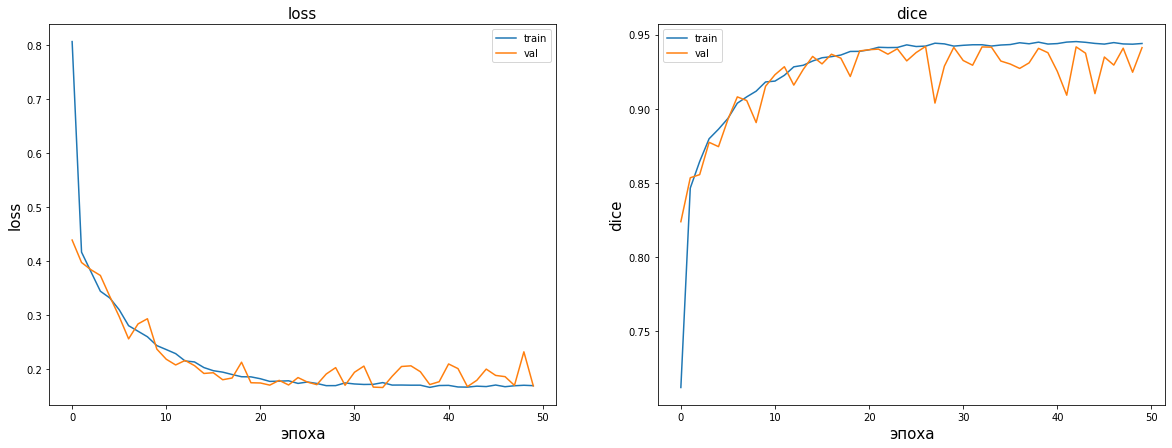

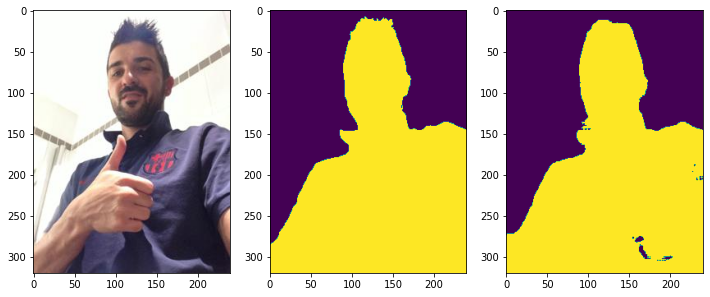

In [13]:
model, history = train_with_aug(model,
                                criterion,
                                optimizer,
                                scheduler,
                                train_batch_gen,
                                val_batch_gen,
                                num_epochs=50)

## Часть где нужно закодировать решения из valid

In [49]:
model.load_state_dict(torch.load('weights/weights__1657297478.9139185'))

<All keys matched successfully>

In [50]:
class TestDataset(Dataset):
    """
    Класс для того чтобы можно было удобно решить задачу на тесте
    """

    def __init__(self, data_path, transform):
        """
        Args:
            data_path: путь до изображений.
            transform: трансформация для изображений.
        """
        self.data_path = data_path
        self.transform = transform

        self.file_list = os.listdir(self.data_path)

        #Теперь отсортируем их, чтобы детерминировать порядок.

        self.file_list.sort()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_filename = self.file_list[idx]
        
        image = cv2.imread(os.path.join(self.data_path, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        transformed = self.transform(image=image)
        image = transformed["image"]

        return image, image_filename

In [51]:
test_transformer = A.Compose(
    transforms = [
                  A.Resize(320, 240),
                  ToTensorV2(),
                  ],
)

In [52]:
test_dataset = TestDataset(DATA_DIR + '/valid', transform=test_transformer)

In [53]:
batch_size = 1
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
y_preds = []
for X_batch, filename in tqdm(test_batch_gen):
    X_batch = X_batch.float().to(device)
    logits = model(X_batch)

    y_preds.append((filename[0][:-4], encode_rle(logits.squeeze().detach().cpu().numpy().argmax(axis=0))))

In [55]:
import pandas as pd

In [60]:
df = pd.DataFrame(y_preds).rename(columns={0: "id", 1: "rle_mask"})
df.to_csv('/home/vapyzh/FaceSegmentationReport/pred_valid_template.csv')

In [123]:
df

,id,rle_mask
0,1315,73 106 182 3 299 130 537 134 770 1 772 141 101...
1,1316,8030 4 8262 18 8501 20 8735 26 8973 28 9211 30...
2,1317,428 1 432 10 662 1 664 7 672 11 900 26 1145 1 ...
3,1318,12549 3 12789 4 13007 31 13039 1 13243 1 13245...
4,1319,22661 3 22901 4 23123 31 23155 3 23359 1 23361...
...,...,...
140,1455,593 10 831 16 1075 8 1313 14 1553 8 1564 1 156...
141,1456,93 17 329 24 569 24 809 24 1053 20 1292 21 152...
142,1457,5871 1 6107 9 6344 14 6583 18 6819 24 7057 27 ...
143,1458,39 120 160 1 278 123 518 124 758 127 998 128 1...


## Часть где нужно сделать htmlку

In [125]:
test_dataset = TestDataset(DATA_DIR + '/test', transform=test_transformer)

In [126]:
batch_size = 1
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [127]:
y_preds = []
for X_batch, filename in tqdm(test_batch_gen):
    X_batch = X_batch.float().to(device)
    logits = model(X_batch)

    y_preds.append(np.array(logits.squeeze().detach().cpu().numpy().argmax(axis=0)).astype(np.uint8) * 255)

In [128]:
from glob import glob

In [129]:
paths_to_imgs = sorted(glob(DATA_DIR + '/test/*'))
pred_masks = np.array(y_preds)

_ = get_html(paths_to_imgs, pred_masks, path_to_save="/home/vapyzh/FaceSegmentationReport/html")